In [1]:
!pip install ema_workbench\[recommended\]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Connect model with the workbench

In [3]:
from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    Constant,
    ema_logging,
    MultiprocessingEvaluator,
    CategoricalParameter,
    Scenario,
    save_results,
    load_results,
)

from lake_model_dps import lake_problem

# allways enable loging when working with the workbench
ema_logging.log_to_stderr(ema_logging.INFO)

# instantiate the model
lake_model = Model("lakeproblem", function=lake_problem)

# specify uncertainties
lake_model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers
lake_model.levers = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]
# specify outcomes
lake_model.outcomes = [
    ScalarOutcome("max_P", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("utility", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", kind=ScalarOutcome.MAXIMIZE),
]

# explore behavior for a default policy

In [4]:
from ema_workbench import Policy

policy = Policy(
    name="default", **{"c1": 0, "c2": 0, "r1": 0.25, "r2": 0.25, "w1": -0.5}
)

In [5]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(1000, policies=policy)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|█████████████████████████████████████| 1000/1000 [00:07<00:00, 136.22it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [6]:
save_results((experiments, outcomes), "./lake_1000.tar.gz")

[MainProcess/INFO] results saved successfully to /Users/jhkwakkel/Documents/GitHub/dmdu_tutorial/src/data/lake_1000.tar.gz


<AxesSubplot:>

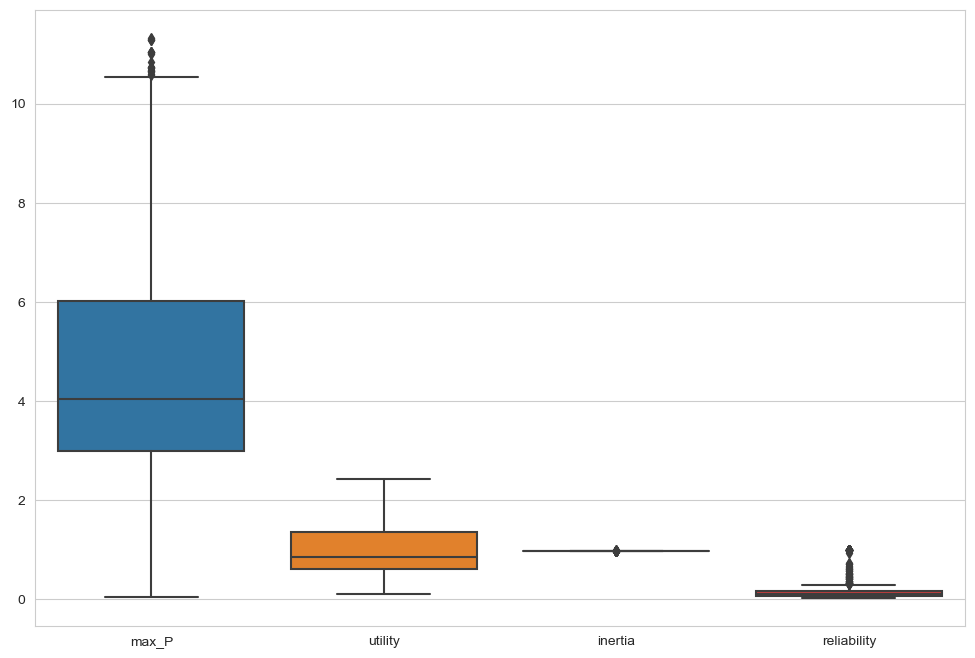

In [7]:
import seaborn as sns

sns.boxplot(pd.DataFrame.from_dict(outcomes))

In [8]:
from ema_workbench.analysis import prim

y = outcomes["max_P"] > 6


prim_alg = prim.Prim(experiments, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 1000 points remaining, containing 252 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.244, coverage: 0.9682539682539683, density: 1.0 restricted_dimensions: 1


In [9]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

# let's explore some more policies the policies

In [10]:
policies = [
    Policy(
        "1",
        **{
            "c1": 0.2888197954456862,
            "c2": -0.2190194678698486,
            "r1": 0.3764326322568374,
            "r2": 1.3001959764740785,
            "w1": 0.8759742948052336,
        }
    ),
    Policy(
        "2",
        **{
            "c1": 0.2569921234197708,
            "c2": -0.0997510677094034,
            "r1": 0.1121004201870498,
            "r2": 1.80205737755322,
            "w1": 0.705474479685676,
        }
    ),
    Policy(
        "3",
        **{
            "c1": 0.1675146491773321,
            "c2": 0.8096284131385665,
            "r1": 0.0714291258956338,
            "r2": 1.6290868456804486,
            "w1": 0.8301165501135789,
        }
    ),
    Policy(
        "4",
        **{
            "c1": 0.2521130028248076,
            "c2": 0.925750373418689,
            "r1": 0.454501075193352,
            "r2": 1.948262369890068,
            "w1": 0.9196054159329452,
        }
    ),
]


```python
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(1000, policies=policies)
save_results((experiments, outcomes), "./data/4policies.tar.gz")
```

In [20]:
experiments, outcomes = load_results("./4policies.tar.gz")

[MainProcess/INFO] results loaded successfully from /Users/jhkwakkel/Documents/GitHub/dmdu_tutorial/src/data/4policies.tar.gz


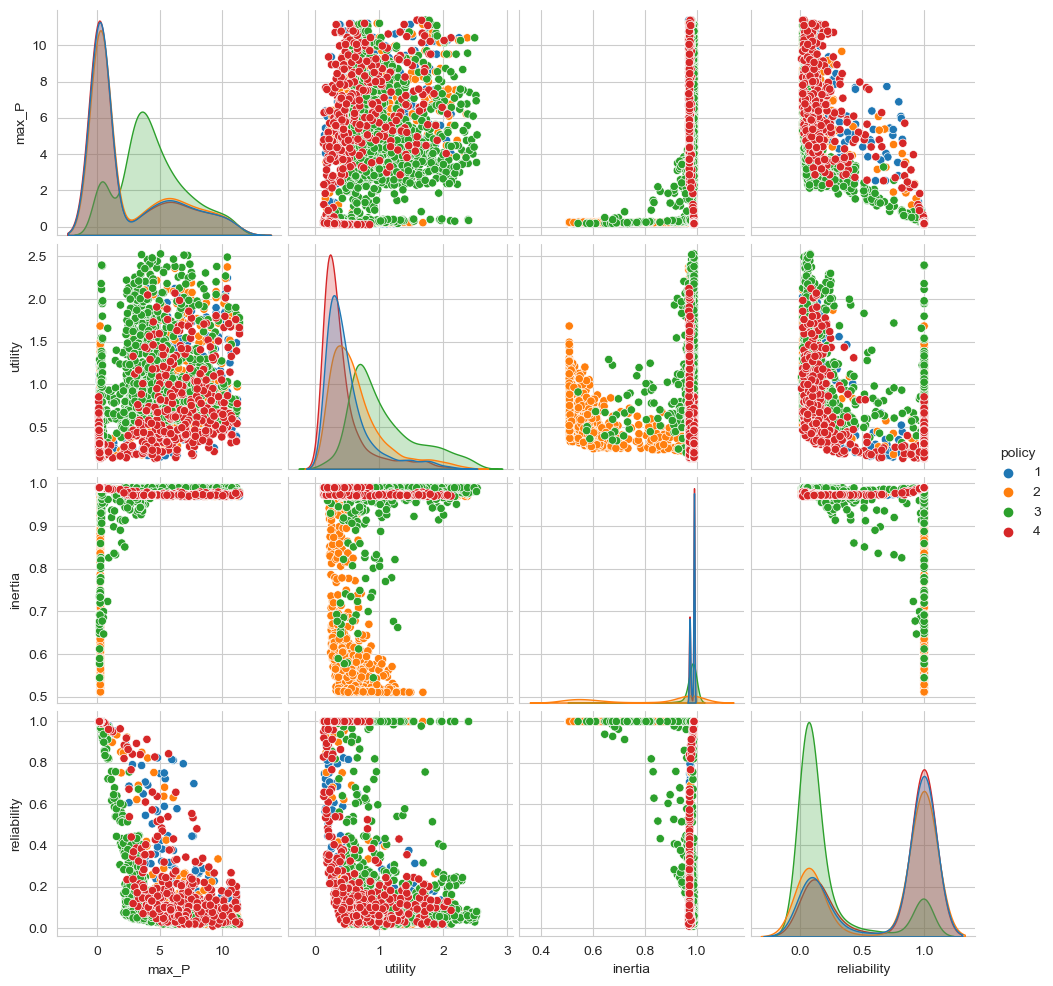

In [21]:
data = pd.DataFrame.from_dict(outcomes)
data["policy"] = experiments.policy
sns.pairplot(data, hue="policy")
plt.show()

In [22]:
y = outcomes["max_P"] > 6
x = experiments.copy()
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 4000 points remaining, containing 836 cases of interest
[MainProcess/INFO] mean: 0.9666666666666667, mass: 0.075, coverage: 0.34688995215311, density: 0.9666666666666667 restricted_dimensions: 6


In [23]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

# calculate robustness

In [24]:
data = pd.DataFrame.from_dict(outcomes)
data["scenario"] = experiments.scenario.astype(int)

In [26]:
def calculate_best_performance(df):
    data = {}

    for outcome in lake_model.outcomes:
        if outcome.kind == ScalarOutcome.MAXIMIZE:
            data[outcome.name] = df[outcome.name].max()
        else:
            data[outcome.name] = df[outcome.name].min()

    return pd.Series(data)

In [27]:
best_performance = data.groupby("scenario").apply(calculate_best_performance)

In [28]:
def calculate_regret(df):
    df = df.set_index("scenario")
    df.drop("policy", axis=1, inplace=True)
    return best_performance - df

In [29]:
data["policy"] = experiments.policy

In [30]:
regret = data.groupby("policy").apply(calculate_regret)

In [31]:
max_regret = regret.groupby(level=0).apply(calculate_best_performance)
max_regret

,max_P,utility,inertia,reliability
policy,,,,
1,-5.427847,2.166400,0.0200,0.3719
2,-8.644346,2.092101,0.4800,0.8708
3,-10.110332,0.610863,0.4459,0.9589
4,-0.002283,2.195416,0.0200,0.0002


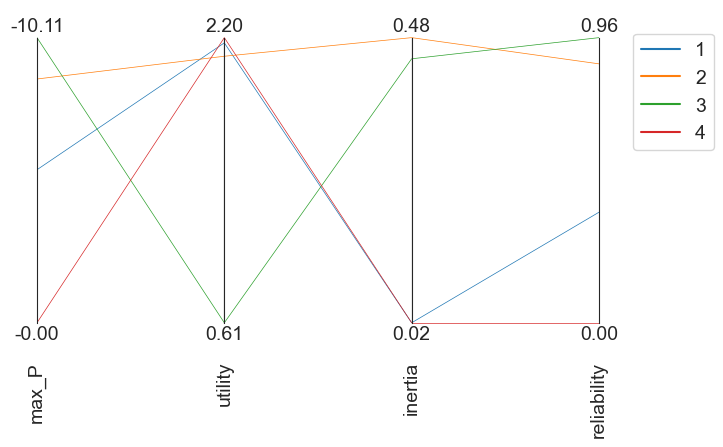

In [33]:
from ema_workbench.analysis import parcoords

colors = sns.color_palette()

limits = parcoords.get_limits(max_regret)
parplot = parcoords.ParallelAxes(limits)


for (i, row), c in zip(max_regret.iterrows(), colors):
    parplot.plot(row, lw=0.5, label=f"{i}", color=c)
parplot.invert_axis("max_P")
parplot.legend()

fig = plt.gcf()
fig.set_size_inches(6, 4)

plt.show()